# Profiling of `maze_dataset` serializing/loading/saving/reading

In [1]:
import os
import itertools
from typing import Callable, Any
import cProfile
import pstats
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from muutils.statcounter import StatCounter

from maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
	set_serialize_minimal_threshold,
)
from maze_dataset.generation.generators import GENERATORS_MAP
from maze_dataset.utils import timeit_fancy, FancyTimeitResult

## Generate Datasets


In [2]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP['gen_dfs'],
	)
    for grid_n, n_mazes in itertools.product(
		[10],
		np.logspace(1, 2, 2, dtype=int).tolist(), # 100, for CI tests
		# np.logspace(1, 3, 5, dtype=int).tolist(), # 1k
		# np.logspace(0, 4, 9, dtype=int).tolist(), # 10k, notebook results from this set
	)
]

datasets: list[MazeDataset] = [MazeDataset.from_config(cfg) for cfg in cfgs]

## Profile

In [3]:
columns: list[str] = ['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds_data: list[dict] = list()


In [4]:
def wrapped_timeit_fancy(
        name: str,
        function: Callable,
        do_profiling: bool,
        repeats: int,
        timing_stat: Callable[[StatCounter], float],
    ) -> tuple[dict, Any]:
    output: dict = dict()

    result: FancyTimeitResult = timeit_fancy(
        function,
        get_return=True,
        do_profiling=do_profiling,
        repeats=repeats,
    )

    output[name] = timing_stat(result.timings)
    output[f"{name}:stats"] = result.timings
    if do_profiling:
        output[f"{name}:profiling"] = result.profile

    return output, result.return_value



def measure_dataset_speed(
        d: MazeDataset, 
        do_profiling: bool = True,
        repeats: int = 1,
        timing_stat: Callable[[StatCounter], float] = StatCounter.min,
    ) -> dict:
    if repeats > 1:
        warnings.warn("Repeats > 1, results might not be accurate due to generation metadata being collected.")
    kwargs_fancy_timeit: dict = dict(
        do_profiling=do_profiling,
        timing_stat=timing_stat,
        repeats=repeats,
    )
    set_serialize_minimal_threshold(None)
    _d_cpy: MazeDataset = copy.deepcopy(d)
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    info_serialize, result_serialize = wrapped_timeit_fancy(
        'serialize_full', _d_cpy._serialize_full, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
        'serialize_minimal', _d_cpy._serialize_minimal, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min)
    _d_cpy = copy.deepcopy(d)

    # info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
    #     'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
    # )
    # row_data.update(info_serialize_min_alt)
    _d_cpy = copy.deepcopy(d)
    info_serialize_cat, result_serialize_cat = wrapped_timeit_fancy(
        'serialize_minimal_soln_cat', _d_cpy._serialize_minimal_soln_cat, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_cat)
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'load_legacy', lambda: MazeDataset._load_legacy(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_full', lambda: MazeDataset._load_full(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal', lambda: MazeDataset._load_minimal(result_serialize_min), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal_soln_cat', lambda: MazeDataset._load_minimal_soln_cat(result_serialize_cat), **kwargs_fancy_timeit
    )[0])
    
    # saving and loading
    path_default: str = f'../data/{d.cfg.to_fname()}.zanj'
    path_min: str = f'../data/{d.cfg.to_fname()}_min.zanj'


    # default
    set_serialize_minimal_threshold(None)
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save', lambda: _d_cpy.save(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)

    # legacy
    set_serialize_minimal_threshold(-1)
    row_data.update(wrapped_timeit_fancy(
        'read_legacy', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    
    
    #default read
    set_serialize_minimal_threshold(None)
    row_data.update(wrapped_timeit_fancy(
        'read', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])

    # minimal
    set_serialize_minimal_threshold(0)
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save_minimal', lambda: _d_cpy.save(file_path=path_min), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)
    
    row_data.update(wrapped_timeit_fancy(
        'read_minimal', lambda: MazeDataset.read(file_path=path_min), **kwargs_fancy_timeit
    )[0])

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    set_serialize_minimal_threshold(None)

    return row_data

## Profile small datasets only

In [5]:
for i, d in enumerate(datasets):
    print(f'Profiling {i+1}/{len(datasets)}:\t{d.cfg}')
    result = measure_dataset_speed(d)
    speeds_data.append(result)
    cols_short: str = str({k : v for k,v in result.items() if ':' not in k})
    print(f"\t{cols_short}")
    print(f"\t{str(d.cfg)}")

Profiling 1/2:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x000001D8945A0790>, maze_ctor_kwargs={})
	{'grid_n': 10, 'n_mazes': 10, 'serialize_full': 0.013439300004392862, 'serialize_minimal': 0.013799299951642752, 'serialize_minimal_soln_cat': 0.010883999988436699, 'load_legacy': 0.1407729999627918, 'load_full': 0.1678476999513805, 'load_minimal': 0.005794700002297759, 'load_minimal_soln_cat': 0.019298500032164156, 'save': 0.20455339993350208, 'read_legacy': 0.15140360000077635, 'read': 0.1278763998998329, 'save_minimal': 0.1919859000481665, 'read_minimal': 0.028081299969926476}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=10

### Results

In [11]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

# SPEEDS.loc[:,"load_legacy":"load_minimal_soln_cat:profiling"]
SPEEDS.loc[:,"read_legacy":"read:profiling"]


,read_legacy,read_legacy:stats,read_legacy:profiling,read,read:stats,read:profiling
0,0.151404,{0.15140360000077635: 1},<pstats.Stats object at 0x000001D894686800>,0.127876,{0.1278763998998329: 1},<pstats.Stats object at 0x000001D894685A80>
1,0.195347,{0.19534740003291517: 1},<pstats.Stats object at 0x000001D894686F80>,0.079277,{0.0792773999273777: 1},<pstats.Stats object at 0x000001D8945AB880>


In [7]:
SPEEDS.columns

Index(['grid_n', 'n_mazes', 'serialize_full', 'serialize_full:stats',
       'serialize_full:profiling', 'serialize_minimal',
       'serialize_minimal:stats', 'serialize_minimal:profiling',
       'serialize_minimal_soln_cat', 'serialize_minimal_soln_cat:stats',
       'serialize_minimal_soln_cat:profiling', 'load_legacy',
       'load_legacy:stats', 'load_legacy:profiling', 'load_full',
       'load_full:stats', 'load_full:profiling', 'load_minimal',
       'load_minimal:stats', 'load_minimal:profiling', 'load_minimal_soln_cat',
       'load_minimal_soln_cat:stats', 'load_minimal_soln_cat:profiling',
       'save', 'save:stats', 'save:profiling', 'read_legacy',
       'read_legacy:stats', 'read_legacy:profiling', 'read', 'read:stats',
       'read:profiling', 'save_minimal', 'save_minimal:stats',
       'save_minimal:profiling', 'read_minimal', 'read_minimal:stats',
       'read_minimal:profiling'],
      dtype='object')

In [18]:


def compute_speedups(speeds: pd.DataFrame) -> pd.DataFrame:
    # for prefix in column_measurement_prefixes:
    #     speeds[f'{prefix}_speedup'] = speeds[f'{prefix}_full'] / speeds[f'{prefix}_minimal']
    speeds['serialize/speedup'] = speeds['serialize_full'] / speeds['serialize_minimal']
    speeds['load_minimal/speedup'] = speeds['load_legacy'] / speeds['load_minimal']
    speeds['load/speedup'] = speeds['load_legacy'] / speeds['load_full']
    speeds['save/speedup'] = speeds['save'] / speeds['save_minimal']
    speeds['read_minimal/speedup'] = speeds['read_legacy'] / speeds['read_minimal']
    speeds['read/speedup'] = speeds['read_legacy'] / speeds['read']

    return speeds

SPEEDS = compute_speedups(SPEEDS)

In [19]:
SPEEDS[[c for c in SPEEDS.columns if ':' not in c]]

,grid_n,n_mazes,serialize_full,serialize_minimal,serialize_minimal_soln_cat,load_legacy,load_full,load_minimal,load_minimal_soln_cat,save,...,save_minimal,read_minimal,serialize/speedup,load_min/speedup,load/speedup,save/speedup,read_min/speedup,read/speedup,load_minimal/speedup,read_minimal/speedup
0,10,10,0.013439,0.013799,0.010884,0.140773,0.167848,0.005795,0.019299,0.204553,...,0.191986,0.028081,0.973912,24.293406,0.838695,1.065461,5.391616,1.183984,24.293406,5.391616
1,10,100,0.013453,0.009632,0.009411,0.059969,0.070306,0.011502,0.032917,0.603583,...,0.124886,0.031639,1.396705,5.213968,0.852981,4.833057,6.174182,2.464099,5.213968,6.174182


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


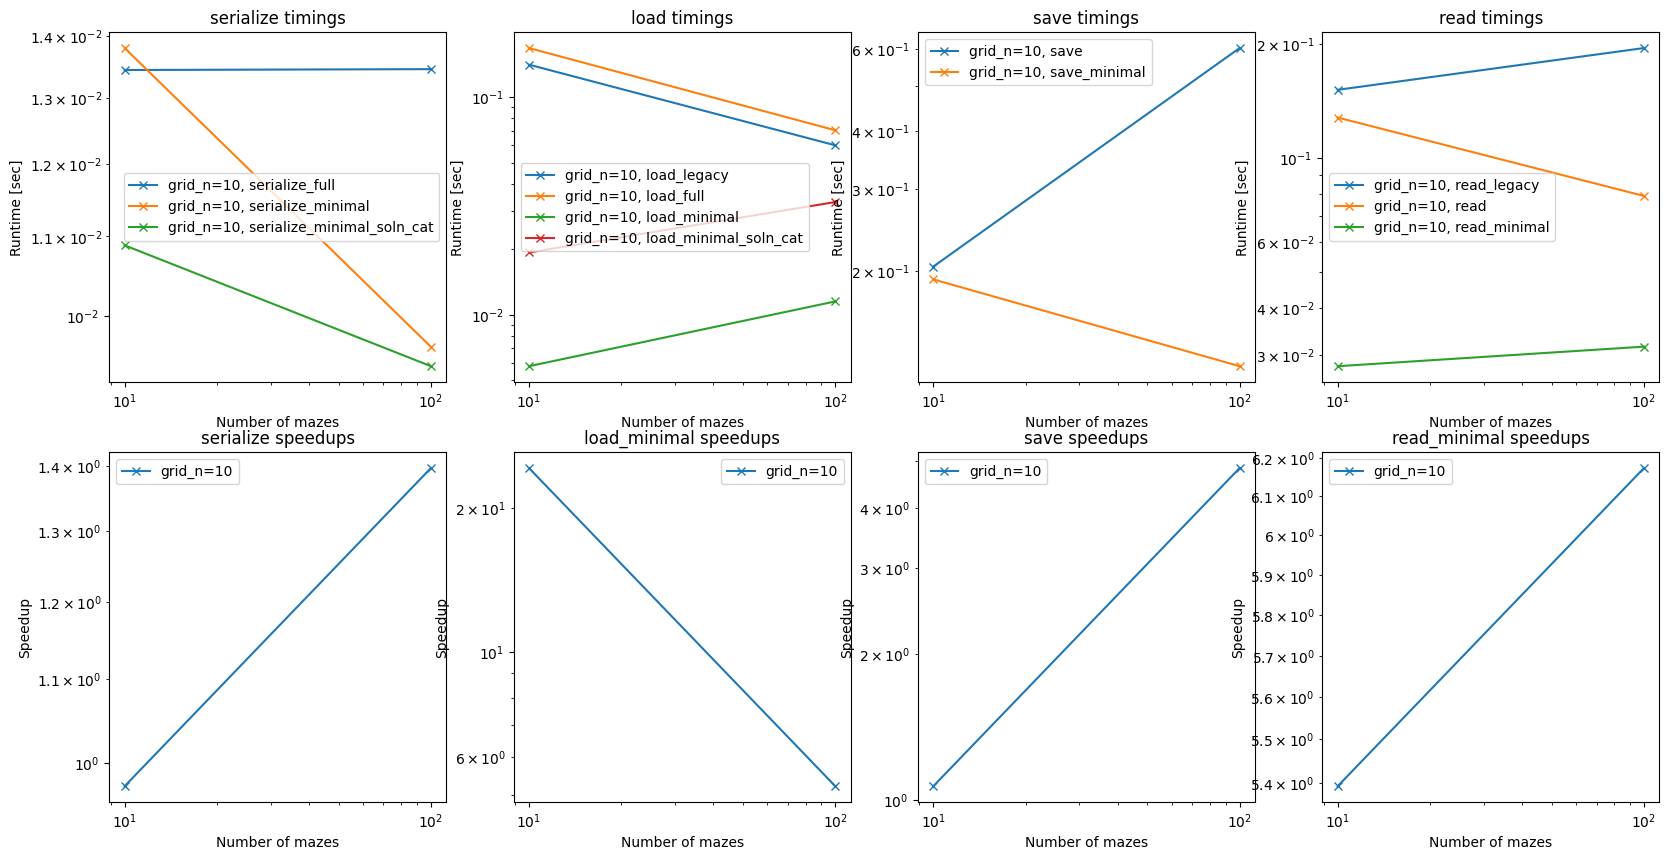

In [20]:
def plot_speeds(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> None:
    n_measurements: int = len(column_measurement_prefixes)
    fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements*5, 10))

    unique_grid_ns: list[int] = speeds['grid_n'].unique().tolist()

    for i, prefix in enumerate(column_measurement_prefixes):
        print(f'Plotting {prefix} timings and speedups')
        for grid_n in unique_grid_ns:
            print(f'Plotting grid_n={grid_n}')
            # raw timings
            ax_timings = axs[0, i]
            speeds_masked = speeds[speeds['grid_n'] == grid_n].sort_values('n_mazes')
            x_n_mazes = speeds_masked['n_mazes']

            # Plotting
            for col in speeds_masked.columns:
                if (prefix in col) and ('speedup' not in col) and (":" not in col):
                    ax_timings.plot(x_n_mazes, speeds_masked[col], "x-", label=f'grid_n={grid_n}, {col}')

            # Setting multiple properties with `set`
            ax_timings.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Runtime [sec]', title=f'{prefix} timings')
            ax_timings.legend()

            # speedups
            ax_speedups = axs[1, i]
            col_name: str = f'{prefix}' if prefix in ('serialize','save') else f'{prefix}_minimal'
            ax_speedups.plot(x_n_mazes, speeds_masked[f"{col_name}/speedup"], "x-", label=f'grid_n={grid_n}')

            # Setting multiple properties with `set` for ax_speedups
            ax_speedups.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Speedup', title=f'{col_name} speedups')
            ax_speedups.legend()


plot_speeds(SPEEDS)


Speedups plotted on the bottom set of axes all show the `_minimal` compared to the legacy performance. `serialize_full` and `save` are unchanged from the legacy version, so speedups are plotted relative to those vectors.

In [10]:
SPEEDS[['grid_n', 'n_mazes', 'serialize_minimal_soln_cat:profiling']]

,grid_n,n_mazes,serialize_minimal_soln_cat:profiling
0,10,1,<pstats.Stats object at 0x0000020457872C90>
1,10,3,<pstats.Stats object at 0x00000204577D7410>
2,10,10,<pstats.Stats object at 0x0000020456764590>
3,10,31,<pstats.Stats object at 0x00000204566509D0>
4,10,100,<pstats.Stats object at 0x000002044CE3A310>
5,10,316,<pstats.Stats object at 0x00000204566C67D0>
6,10,1000,<pstats.Stats object at 0x00000204564D6A90>
7,10,3162,<pstats.Stats object at 0x00000204565D2310>
8,10,10000,<pstats.Stats object at 0x000002044A88F010>


In [11]:
SPEEDS['serialize_minimal_soln_cat:profiling'][len(SPEEDS)-1].sort_stats('tottime').print_stats()

         16044 function calls (15819 primitive calls) in 0.044 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.026    0.026    0.044    0.044 maze_dataset.py:407(_serialize_minimal_soln_cat)
    10001    0.010    0.000    0.010    0.000 {built-in method numpy.array}
      724    0.002    0.000    0.004    0.000 tokenize.py:433(_tokenize)
        1    0.002    0.002    0.002    0.002 maze_dataset.py:414(<listcomp>)
      671    0.001    0.000    0.001    0.000 {method 'match' of 're.Pattern' objects}
        1    0.001    0.001    0.005    0.005 inspect.py:1224(getblock)
      723    0.000    0.000    0.000    0.000 inspect.py:1181(tokeneater)
      723    0.000    0.000    0.001    0.000 <string>:1(<lambda>)
    195/2    0.000    0.000    0.006    0.003 json_serialize.py:231(json_serialize)
      723    0.000    0.000    0.000    0.000 {built-in method __new__ of type object at 0x00007FFB8BC98F90}
      8/1  